<a href="https://colab.research.google.com/github/Thomas101Shen/Crank-Nicholson_delta_hedging/blob/main/%E2%80%9C%E6%AC%A2%E8%BF%8E%E4%BD%BF%E7%94%A8_Colaboratory%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import bisect
import matplotlib.pyplot as plt



In [ ]:
# Black-Scholes call option pricing formula
def black_scholes_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)  # Payoff at maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate implied volatility
def implied_volatility(C_mkt, S, K, T, r):
    def objective(sigma):
        price = black_scholes_call_price(S, K, T, r, sigma)
        return price - C_mkt
    try:
        return bisect(objective, 1e-6, 10)  # Expanded range
    except ValueError:
        return np.nan

# Function to calculate call Delta using the Black-Scholes model
def black_scholes_call_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

In [ ]:
# Crank-Nicholson method for solving the Black-Scholes PDE
def crank_nicholson(S, K, r, T, sigma, N=100, M=100):
    dt = T / N  # Time step size
    S_min = 0
    S_max = 3 * S
    dS = S_max / M

    # Initialize the price grid
    S_grid = np.linspace(S_min, S_max, M + 1)
    V = np.maximum(S_grid - K, 0)  # Option value at maturity

    # Coefficients for Crank-Nicolson
    alpha = 0.25 * dt * ((sigma**2 * S_grid**2) / (dS**2) - r * S_grid / dS)
    beta = -0.5 * dt * (sigma**2 * S_grid**2 / (dS**2) + r)
    gamma = 0.25 * dt * ((sigma**2 * S_grid**2) / (dS**2) + r * S_grid / dS)

    # Implicit matrix
    A = np.zeros((M-1, M-1))
    B = np.zeros((M-1, M-1))
    for i in range(1, M):
        if i > 1:
            A[i-1, i-2] = -alpha[i]
            B[i-1, i-2] = alpha[i]
        A[i-1, i-1] = 1 - beta[i]
        B[i-1, i-1] = 1 + beta[i]
        if i < M-1:
            A[i-1, i] = -gamma[i]
            B[i-1, i] = gamma[i]

    # Time stepping
    for _ in range(N):
        V_inner = V[1:M]
        V_inner = np.linalg.solve(A, B @ V_inner)
        V[1:M] = V_inner
        V[-1] = S_max - K * np.exp(-r * (T - _ * dt))  # Boundary condition at S -> infinity

    return np.interp(S, S_grid, V)


In [ ]:
# Stability and convergence test with plot
def stability_convergence_test(S, K, r, T, sigma):
    errors = []
    crank_prices = []
    grid_sizes = [50, 100, 200, 400, 800]  # Extended grid sizes for testing
    bs_price = black_scholes_call_price(S, K, T, r, sigma)
    print(f"Black-Scholes Analytical Price: {bs_price:.4f}")

    for M in grid_sizes:
        crank_price = crank_nicholson(S, K, r, T, sigma, N=M, M=M)
        error = abs(crank_price - bs_price)
        crank_prices.append(crank_price)
        errors.append(error)
        print(f"M={M}, Crank-Nicholson Price: {crank_price:.4f}, Error: {error:.4e}")

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(grid_sizes, crank_prices, label="Crank-Nicholson Price", marker='o')
    plt.axhline(y=bs_price, color='r', linestyle='--', label="Black-Scholes Analytical Price")
    plt.title("Convergence of Crank-Nicholson Method")
    plt.xlabel("Grid Size (M)")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()
    plt.show()

    # Plotting errors
    plt.figure(figsize=(10, 6))
    plt.plot(grid_sizes, errors, label="Error", marker='o')
    plt.title("Error Convergence with Grid Size")
    plt.xlabel("Grid Size (M)")
    plt.ylabel("Error")
    plt.yscale('log')  # Log scale for better visualization
    plt.legend()
    plt.grid()
    plt.show()

    return errors

Crank-Nicholson Option Price: 2.6373
Implied Volatility: 0.1991
Black-Scholes Analytical Price: 2.6119
M=50, Crank-Nicholson Price: 2.7071, Error: 9.5200e-02
M=100, Crank-Nicholson Price: 2.6373, Error: 2.5439e-02
M=200, Crank-Nicholson Price: 2.6180, Error: 6.1436e-03
M=400, Crank-Nicholson Price: 2.6135, Error: 1.5615e-03
M=800, Crank-Nicholson Price: 2.6123, Error: 3.8711e-04


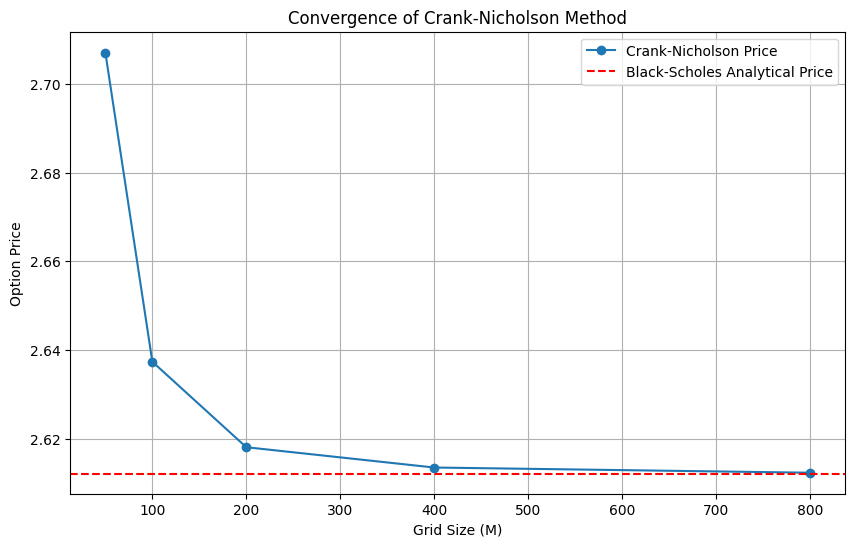

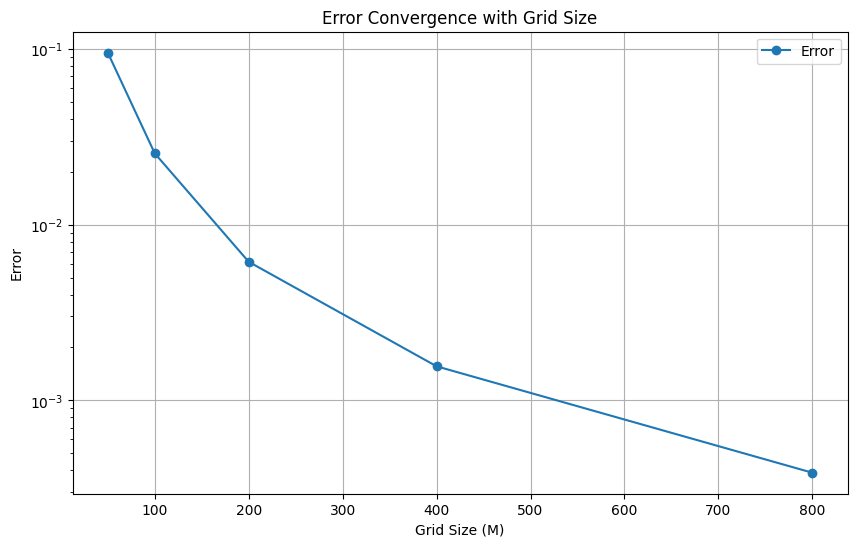

[0.09519977399371449,
 0.025438901786194457,
 0.0061435692245495055,
 0.0015615189255542283,
 0.0003871107136954599]

In [ ]:
# Example parameters
C_mkt = 2.59
S = 100
K = 110
T = 0.5
r = 0.03
sigma = 0.2

# Crank-Nicholson output
crank_price = crank_nicholson(S, K, r, T, sigma)
print(f"Crank-Nicholson Option Price: {crank_price:.4f}")

# Example for implied volatility calculation
sigma_imp = implied_volatility(C_mkt, S, K, T, r)
print(f"Implied Volatility: {sigma_imp:.4f}")

# Run stability and convergence test
stability_convergence_test(S, K, r, T, sigma)